# Exploring election tweets from Tweet the People project

I want to build a Naive Bayes classifier that predicts whether a given tweet is about a Republican or Democrat presidential candidate.

(For the purposes of this model, I'll assume that a tweet is "about a Republican" if it originally contained the words `donaldtrump`, `donald trump`, `mikepence`, or `mike pence`, and the same for the Democrat candidates. But I'll strip these actual terms out before building the model, otherwise the model wouldn't be building a prediction based on anything other than the presence of these terms.)

Before I build this model, I'd like to know:

- Is there a class imbalance that I need to take into account in my model?
- Some basic stats about the tweets:
    - Average no. words (and whether it differs by candidate)
    - Popular terminology (using TF-IDF)
- Bonus: Check distribution of sentiment in each ticket
- Bonus: I'll be stripping out hashtags, but I'm curious to know about the trends here.

## Step 1: reading in data, basic data cleaning

In [163]:
import re
import pandas as pd
import numpy as np
import random

from spacy.lang.en import English
from spacy.tokenizer import Tokenizer

In [109]:
nlp = English()

In [110]:
dict_replace = {"-": " ", "\.": "", "\?": "\'", "\s+": " ", "&amp;" : "and"}

In [159]:
tweets = pd.read_csv('/Users/laraehrenhofer/Documents/Coding_Projects/git_repos/tweet-the-people-legacy/data/tweet_pg.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [160]:
tweets = tweets[['text', 'politician', 'date', 'sentiment', 'ticket']]

Some tweets were wrongly inserted with the date as the politician -- I'm going to delete these data points from the sample. (This removes about 30 tweets.)

In [118]:
politicians = ['kamalaharris', 'donaldtrump', 'joebiden', 'mikepence']

In [167]:
def is_politician(politician):
    '''
    Returns boolean indicating whether input is a member of politicians list
    '''
    if politician in politicians:
        return politician
    else:
        return np.NaN

In [188]:
tweets['politician'] = tweets['politician'].apply(lambda x: is_politician(x))
tweets = tweets.dropna()

In [189]:
def get_handles_hashtags(text):
    '''
    Returns separate lists of hashtags and user handles in the text
    '''
    handles = re.findall('\B\@\w+', text)
    hashtags = re.findall('\B\#\w+', text)
    return handles, hashtags

In [190]:
def strip_out_weird_symbols(text):
    '''
    Replaces special symbols that get messed up eg. replaces &amp; with and (as they are functionally identical)
    See dict_replace for replacements
    '''
    for key, value in dict_replace.items():
        sub = re.sub(key, value, text)
        text = sub
    text = re.sub(r'\\', '', text)
    text = re.sub('\s+', ' ', text)
    return text

In [191]:
def strip_out_handles_hashtags(text):
    '''
    Removes handles and hashtags
    '''
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    return text

In [192]:
def clean_text(text):
    '''
    - Removes handles & hashtags from text
    - Handles odd symbols
    - Tokenisation
    '''
    cleaned = strip_out_weird_symbols(text)
    cleaned = strip_out_handles_hashtags(cleaned)
    doc = nlp(cleaned)
    cleaned = [token.orth_.lower() for token in doc if not token.is_punct]
    cleaned = [item for item in cleaned if not re.search('\s+', item)]
    text_len = len(cleaned)
    cleaned = ' '.join(cleaned)
    return cleaned, text_len

In [193]:
tweets[['handles', 'hashtags']] = tweets.apply(lambda row: pd.Series(get_handles_hashtags(row['text'])), axis=1)

In [194]:
tweets[['clean_text', 'text_len']] = tweets.apply(lambda row: pd.Series(clean_text(row['text'])), axis=1)

In [197]:
# save this version of tweets data for later

tweets.to_csv('./tweet_minimal.csv', index=False)

## Step 2: check class imbalance

Quick count of how many tweets per candidate and per ticket.

In [201]:
# count by candidate

cand = tweets.groupby(['politician']).count()
cand = cand['text']
cand

politician
donaldtrump      95427
joebiden        103596
kamalaharris     85274
mikepence        32389
Name: text, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1425996d0>],
      dtype=object)

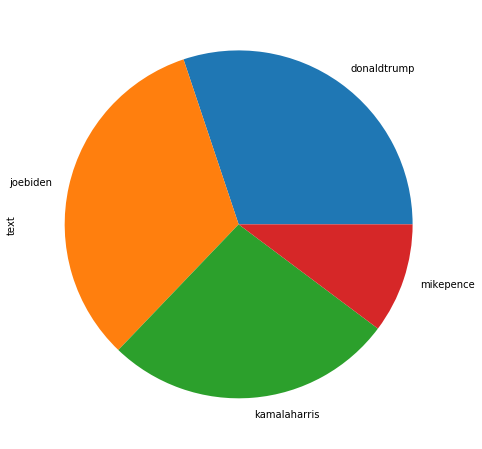

In [203]:
# comparison

cand.plot(kind='pie', subplots=True, figsize=(8, 8))

In [202]:
ticket = tweets.groupby(['ticket']).count()
ticket = ticket['text']
ticket

ticket
Democrat      188870
Republican    127816
Name: text, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1243026d0>],
      dtype=object)

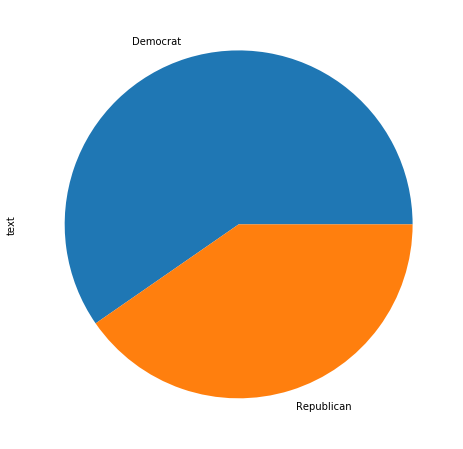

In [204]:
ticket.plot(kind='pie', subplots=True, figsize=(8, 8))

In [207]:
ticket[0]/sum(ticket)

0.5963951674529344

There's more tweets about Democrat than about Republican candidates, but that's quite probably due to the low rates of tweets about Mike Pence. Still, the discrepancy isn't monstrous (59% vs 41%), so I won't do any resampling to correct this.